In [11]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import pickle
from urllib.parse import unquote
from torch.utils.data import Dataset, random_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GraphNorm
from tqdm import tqdm
import random

from torch_geometric.nn import TransformerConv, global_mean_pool

# Load Data

In [12]:
# Load text data
data = pd.read_csv(f"../../data/full_text_data.csv")

In [13]:
# Load links
links = pd.read_csv("../../data/Wikispeedia/links.tsv", sep="\t", names=["src", "tgt"], skiprows=12)
links["src"] = links["src"].map(lambda x: unquote(x))
links["tgt"] = links["tgt"].map(lambda x: unquote(x))

# Create adjacency matrix
ordered_data_titles = data["title"].tolist()
src_indices = links["src"].map(lambda x: ordered_data_titles.index(x))
tgt_indices = links["tgt"].map(lambda x: ordered_data_titles.index(x))
A = torch.zeros((len(ordered_data_titles), len(ordered_data_titles)))
A[src_indices, tgt_indices] = 1

In [14]:
# Load coherence graph
with open("../../data/coherence_graph.pkl", 'rb') as handle:
    coherence_graph = pickle.load(handle)

# Combine coherence graph with base links
edge_features = A * coherence_graph

/var/folders/kt/8729r9s16_15cc905qks8zl40000gn/T/ipykernel_59808/3991216429.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  edge_features = A * coherence_graph


In [15]:
# Load node embeddings
with open("../../data/gpt4_embeddings.pkl", 'rb') as handle:
    obj = pickle.load(handle)
    node_static_embeddings = obj["embeddings"]
    del obj
node_static_embeddings = torch.tensor(node_static_embeddings, dtype=torch.float)

/var/folders/kt/8729r9s16_15cc905qks8zl40000gn/T/ipykernel_59808/3588909332.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_static_embeddings = torch.tensor(node_static_embeddings, dtype=torch.float)


In [16]:
# Load user-extracted paths
paths_data = pd.read_csv(f"../../data/paths_no_back_links.tsv", sep="\t")
paths_data = paths_data[~(paths_data["rating"].isna())]

# Filter paths with at least four distinct pages
paths_data = paths_data[paths_data["path"].apply(lambda x: len(set(x.split(";"))) >= 4)]

# Map titles to indices
title_to_index = {unquote(title): idx for idx, title in enumerate(data['title'])}
paths = paths_data['path'].apply(lambda path: [title_to_index[unquote(title)] for title in path.split(';')]).tolist()
ratings = (paths_data['rating'] - 1).tolist()  # 0-indexed ratings

# Binary ratings
# ratings = [1 if r > 1 else 0 for r in ratings]

set(ratings)

{0.0, 1.0, 2.0, 3.0, 4.0}

In [17]:
class PathDataset(Dataset):
    def __init__(self, paths, ratings, node_embeddings, edge_features):
        self.paths = paths
        self.ratings = ratings
        self.node_embeddings = node_embeddings
        self.edge_features = edge_features

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        rating = self.ratings[idx]
        nodes, edge_index, edge_weight = self.get_subgraph_edges(path)

        x = self.node_embeddings[nodes]

        data = Data(
            x=x,
            edge_index=edge_index,
            edge_weight=edge_weight,
            y=torch.tensor([rating], dtype=torch.long)
        )
        return data

    def get_subgraph_edges(self, path):
        nodes = list(set(path))
        node_to_idx = {node: idx for idx, node in enumerate(nodes)}
        edges = []
        edge_weights = []
        for i in nodes:
            for j in nodes:
                weight = self.edge_features[i, j]
                if weight > 0:
                    edges.append([node_to_idx[i], node_to_idx[j]])
                    edge_weights.append(weight)
        if edges:
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            edge_weight = torch.tensor(edge_weights, dtype=torch.float)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_weight = torch.tensor([], dtype=torch.float)
        return nodes, edge_index, edge_weight

# Create dataset
dataset = PathDataset(paths, ratings, node_static_embeddings, edge_features)

# Split dataset
train_ratio = 0.85
val_ratio = 0.05
test_ratio = 0.1
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# Create data loaders
batch_size = 6
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/Users/jiahaoxu/Github/wikispeedia-gnn/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [18]:
# Counts occurrences of each class
class_counts = torch.bincount(
    torch.tensor(ratings)[train_dataset.indices].to(torch.int64)
)

# Calculate weights as the inverse of class frequencies
class_weights = 1.0 / class_counts.float()

# Normalize the weights so that they sum to the number of classes
class_weights = class_weights / class_weights.sum() * len(class_counts)

class_weights

tensor([0.4479, 0.3379, 0.4016, 1.0386, 2.7740])

#  Model

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import TransformerConv, global_mean_pool, GraphNorm

class GraphTransformerModelWithGRU(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, heads=4, dropout=0.2, gru_hidden_size=64, gru_num_layers=1):
        super(GraphTransformerModelWithGRU, self).__init__()
        
        # Transformer Convolutional Layers
        self.conv1 = TransformerConv(
            in_channels, hidden_channels // heads, heads=heads, edge_dim=1, dropout=dropout
        )
        self.norm1 = GraphNorm(hidden_channels)
        
        self.conv2 = TransformerConv(
            hidden_channels, hidden_channels // heads, heads=heads, edge_dim=1, dropout=dropout
        )
        self.norm2 = GraphNorm(hidden_channels)
        
        # GRU Layer
        self.gru = nn.GRU(
            input_size=hidden_channels,
            hidden_size=gru_hidden_size,
            num_layers=gru_num_layers,
            batch_first=True
        )
        
        # Two MLP Layers
        self.mlp1 = nn.Linear(gru_hidden_size, hidden_channels)
        self.mlp2 = nn.Linear(hidden_channels, hidden_channels)
        
        # Classifier
        self.classifier = nn.Linear(hidden_channels, num_classes)
        
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_weight, data.batch

        # Reshape edge_weight to [num_edges, 1] if it exists
        edge_attr = edge_weight.view(-1, 1) if edge_weight is not None else None

        # First Transformer Conv Layer
        x = self.conv1(x, edge_index, edge_attr)
        x = self.norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Second Transformer Conv Layer
        x = self.conv2(x, edge_index, edge_attr)
        x = self.norm2(x)
        x = F.relu(x)

        # Process graphs individually through GRU
        graphs_embeddings = []
        unique_graphs = batch.unique()
        for graph_id in unique_graphs:
            graph_mask = (batch == graph_id)
            graph_node_embeddings = x[graph_mask].unsqueeze(0)
            _, hidden_state = self.gru(graph_node_embeddings)
            graph_embedding = hidden_state[-1, 0]
            graphs_embeddings.append(graph_embedding)
        
        # Stack all graph embeddings
        x = torch.stack(graphs_embeddings)
        
        # First MLP Layer
        x = self.mlp1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second MLP Layer
        x = self.mlp2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final Classifier
        x = self.classifier(x)
        
        return x

# Training

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = class_weights.to(device)

# Instantiate the updated model with GRU
model = GraphTransformerModelWithGRU(
    in_channels=node_static_embeddings.shape[1],
    hidden_channels=512,
    num_classes=5,  # Adjust based on your task
    # heads=4,
    dropout=0.2,
    gru_hidden_size=512,  # Should align with model's hidden_channels if desired
    gru_num_layers=3     # Number of GRU layers
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

def train():
    model.train()
    total_loss = 0
    for data in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return correct / total

best_val_acc = 0
for epoch in range(1, 11):
    loss = train()
    val_acc = evaluate(val_loader)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Save the best model
        torch.save(model.state_dict(), '.best_model.pth')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

  0%|          | 0/3669 [00:00<?, ?it/s]/var/folders/kt/8729r9s16_15cc905qks8zl40000gn/T/ipykernel_59808/57342433.py:22: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y=torch.tensor([rating], dtype=torch.long)
100%|██████████| 3669/3669 [06:32<00:00,  9.34it/s]


Epoch: 001, Loss: 1.5841, Val Acc: 0.3570


100%|██████████| 3669/3669 [07:01<00:00,  8.70it/s]


Epoch: 002, Loss: 1.4093, Val Acc: 0.3640


100%|██████████| 3669/3669 [07:05<00:00,  8.62it/s]


Epoch: 003, Loss: 1.3934, Val Acc: 0.3702


100%|██████████| 3669/3669 [07:09<00:00,  8.55it/s]


Epoch: 004, Loss: 1.4253, Val Acc: 0.3601


100%|██████████| 3669/3669 [07:16<00:00,  8.41it/s]


Epoch: 005, Loss: 1.4523, Val Acc: 0.3470


100%|██████████| 3669/3669 [07:38<00:00,  8.01it/s]


Epoch: 006, Loss: 1.4221, Val Acc: 0.3292


100%|██████████| 3669/3669 [07:30<00:00,  8.15it/s]


Epoch: 007, Loss: 1.4597, Val Acc: 0.4073


100%|██████████| 3669/3669 [07:37<00:00,  8.03it/s]


Epoch: 008, Loss: 1.4099, Val Acc: 0.4034


100%|██████████| 3669/3669 [07:39<00:00,  7.99it/s]


Epoch: 009, Loss: 1.4165, Val Acc: 0.2898


100%|██████████| 3669/3669 [07:26<00:00,  8.23it/s]


Epoch: 010, Loss: 1.5134, Val Acc: 0.3903


In [21]:
# Load the best model
model.load_state_dict(torch.load('.best_model.pth'))

test_acc = evaluate(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

/var/folders/kt/8729r9s16_15cc905qks8zl40000gn/T/ipykernel_59808/3427124251.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('.best_model

Test Accuracy: 0.3988


/var/folders/kt/8729r9s16_15cc905qks8zl40000gn/T/ipykernel_59808/57342433.py:22: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y=torch.tensor([rating], dtype=torch.long)


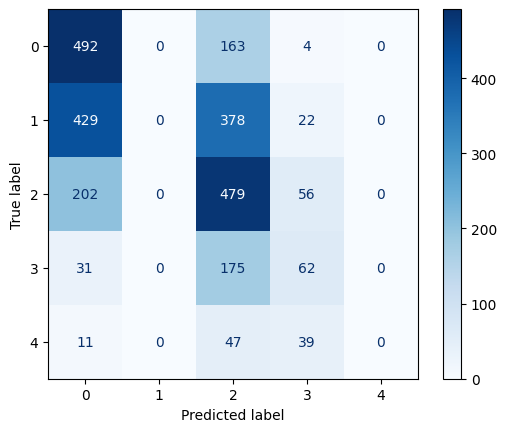

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def conf_matrix(model, dataset_loader):
    # Pass the testing loader through the model
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in dataset_loader:
            batch = batch.to(device)  # Move batch to the same device as the model
            logits = model(batch)  # Pass the entire batch to the model
            preds = logits.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Assuming your trained model is named 'model' and your DataLoader is 'test_loader'
conf_matrix(model, test_loader)

In [23]:
# Function to print the hyperparameters
def print_hyperparameters():
    print("learning_rate   =", "5e-3")
    print("weight_decay    =", "5e-4")
    print("num_epochs      =", 10)
    print("------")
    # print("dropout            =", dropout)

# Call the function to print the hyperparameters
print_hyperparameters()
print(model.parameters)

learning_rate   = 5e-3
weight_decay    = 5e-4
num_epochs      = 10
------
<bound method Module.parameters of GraphTransformerModelWithGRU(
  (conv1): TransformerConv(1536, 128, heads=4)
  (norm1): GraphNorm(512)
  (conv2): TransformerConv(512, 128, heads=4)
  (norm2): GraphNorm(512)
  (gru): GRU(512, 512, num_layers=3, batch_first=True)
  (mlp1): Linear(in_features=512, out_features=512, bias=True)
  (mlp2): Linear(in_features=512, out_features=512, bias=True)
  (classifier): Linear(in_features=512, out_features=5, bias=True)
)>
